<a href="https://colab.research.google.com/github/fjadidi2001/fake_news_detection/blob/main/BERTGCNAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Setup and Data Loading



In [1]:
# Install dependencies
!pip install torch torch-geometric transformers imbalanced-learn -q

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.preprocessing import StandardScaler
import networkx as nx
from scipy import io as sio

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Projects/Hayat/facebook-fact-check.csv', encoding='latin-1')

# Extract network features and handle NaN
network_features = df[['share_count', 'reaction_count', 'comment_count']].fillna(0).values  # Replace NaN with 0
print("NaN in network features before filling:", np.isnan(network_features).any())  # Should be True if NaN exists
print("NaN in network features after filling:", np.isnan(network_features).any())  # Should be False

# Standardize network features
scaler = StandardScaler()
X_net_std = scaler.fit_transform(network_features)  # (2282, 3)
print("NaN in X_net_std:", np.isnan(X_net_std).any())  # Should be False

# Save standardized features
sio.savemat('network.mat', {'X_net_std': X_net_std})
print("Network features shape:", X_net_std.shape)

# Prepare labels (binary classification)
labels = df['Rating'].apply(lambda x: 0 if x == 'mostly true' else 1).values  # 0: mostly true, 1: others
y = np.array(labels)
print("Label distribution:", np.bincount(y))  # [1669, 613]

# Move files to Google Drive
!mv /content/network.mat /content/drive/MyDrive/Projects/Hayat/
print("Network features saved to Google Drive")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.4 MB/s eta 0:00:00
Mounted at /content/drive
NaN in network featur

## Bar Chart (Class Distribution):



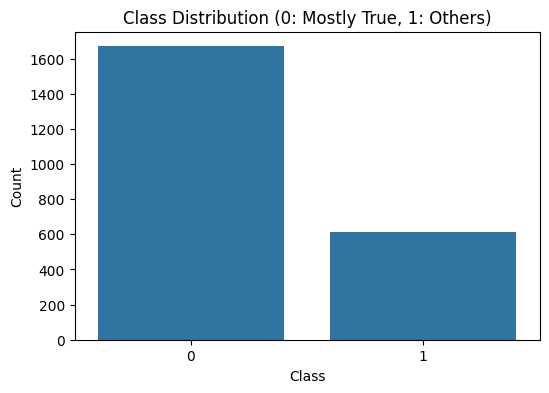

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Class Distribution (0: Mostly True, 1: Others)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## Pie Chart (Class Proportions):


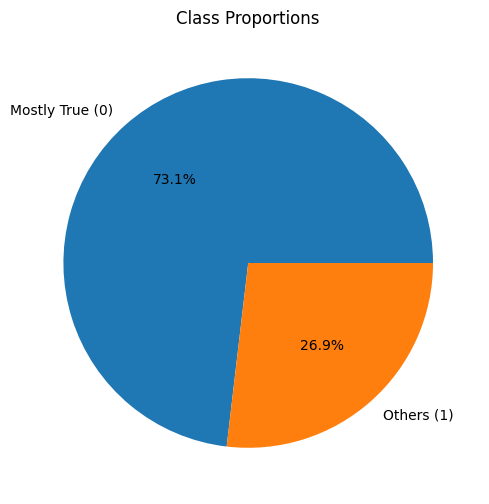

In [3]:
plt.figure(figsize=(6, 6))
plt.pie(np.bincount(y), labels=['Mostly True (0)', 'Others (1)'], autopct='%1.1f%%')
plt.title("Class Proportions")
plt.show()

## Box Plot (Feature Spread):



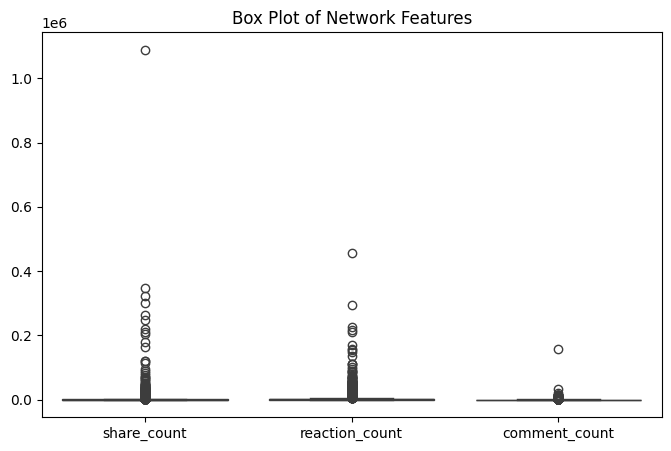

In [4]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df[['share_count', 'reaction_count', 'comment_count']].fillna(0))
plt.title("Box Plot of Network Features")
plt.show()

## Table (Summary Statistics):



In [5]:
print("Summary Statistics of Network Features:")
print(pd.DataFrame(network_features, columns=['share_count', 'reaction_count', 'comment_count']).describe())

Summary Statistics of Network Features:
        share_count  reaction_count  comment_count
count  2.282000e+03     2282.000000    2282.000000
mean   3.920741e+03     5359.583260     515.649869
std    2.937889e+04    19118.816835    3567.822982
min    0.000000e+00        0.000000       0.000000
25%    2.000000e+01      149.000000      36.250000
50%    8.700000e+01      543.000000     131.000000
75%    6.800000e+02     2414.250000     390.000000
max    1.088995e+06   456458.000000  159047.000000


# Step 2: Social Branch (Graph Construction and GCN Embeddings)



In [6]:
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_self_loops

# Load standardized network features
X_net_std = sio.loadmat('/content/drive/MyDrive/Projects/Hayat/network.mat')['X_net_std']
print("NaN in X_net_std (loaded):", np.isnan(X_net_std).any())  # Should be False

# Construct graph
G = nx.Graph()
for idx in range(len(df)):
    G.add_node(idx, features=X_net_std[idx])
account_groups = df.groupby('account_id').indices
for account_id, indices in account_groups.items():
    indices = list(indices)
    for i in range(len(indices)):
        for j in range(i + 1, len(indices)):
            G.add_edge(indices[i], indices[j])
print("Graph nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())

# Prepare GNN data
edges = list(G.edges)
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
x = torch.tensor(X_net_std, dtype=torch.float)
data = Data(x=x, edge_index=edge_index)
edge_index, _ = add_self_loops(data.edge_index, num_nodes=data.num_nodes)
data.edge_index = edge_index
print("GNN Data:", data)

# Define GCN model
class GCN(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=64, out_channels=128):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.relu = nn.ReLU()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Compute GCN embeddings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gcn_model = GCN().to(device)
data = data.to(device)
gcn_model.eval()
with torch.no_grad():
    gcn_embeddings = gcn_model(data)  # (2282, 128)
print("GCN Embeddings shape:", gcn_embeddings.shape)
print("NaN in gcn_embeddings:", torch.isnan(gcn_embeddings).any().item())  # Should be False

# Save GCN model and embeddings
torch.save(gcn_model.state_dict(), 'gcn_model.pth')
torch.save(gcn_embeddings.cpu(), 'gcn_embeddings.pt')
print("GCN model and embeddings saved")

# Move to Google Drive
!mv /content/gcn_model.pth /content/drive/MyDrive/Projects/Hayat/
!mv /content/gcn_embeddings.pt /content/drive/MyDrive/Projects/Hayat/
print("GCN model and embeddings moved to Google Drive")

NaN in X_net_std (loaded): False
Graph nodes: 2282 Edges: 368312
GNN Data: Data(x=[2282, 3], edge_index=[2, 370594])
GCN Embeddings shape: torch.Size([2282, 128])
NaN in gcn_embeddings: False
GCN model and embeddings saved
GCN model and embeddings moved to Google Drive


## Histogram (Node Degree Distribution):



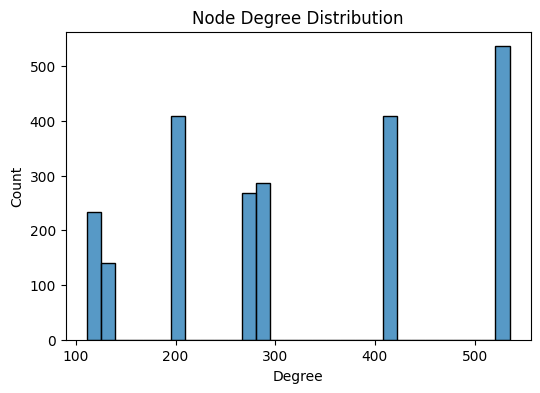

In [7]:
degrees = [d for _, d in G.degree()]
plt.figure(figsize=(6, 4))
sns.histplot(degrees, bins=30)
plt.title("Node Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

## Heatmap (Feature Correlation):



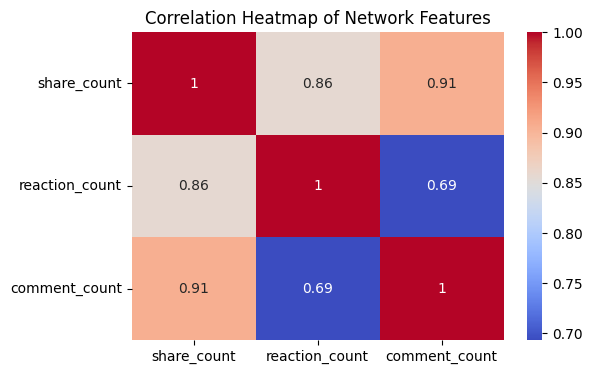

In [8]:
plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(X_net_std, columns=['share_count', 'reaction_count', 'comment_count']).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Network Features")
plt.show()

## Table (Graph Statistics):



In [9]:
print("Graph Statistics:")
print(pd.DataFrame({
    'Nodes': [G.number_of_nodes()],
    'Edges': [G.number_of_edges()],
    'Avg Degree': [np.mean([d for _, d in G.degree()])]
}))

Graph Statistics:
   Nodes   Edges  Avg Degree
0   2282  368312  322.797546


# Step 3: Text Branch (BERT + Attention Embeddings)



In [10]:
from transformers import BertTokenizer, BertModel

# Define Attention Layer
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, embeddings):
        scores = self.attention(embeddings)  # (batch_size, seq_len, 1)
        scores = torch.softmax(scores, dim=1)  # (batch_size, seq_len, 1)
        context = torch.sum(embeddings * scores, dim=1)  # (batch_size, hidden_dim)
        return context

# BERT Setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()
attention_layer = Attention(hidden_dim=768).to(device)

# Process texts with BERT + Attention
batch_size = 32
bert_embeddings = []
texts = df['Context Post'].fillna("").tolist()

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i + batch_size]
    inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=117)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = bert_model(**inputs)
        token_embeddings = outputs.last_hidden_state  # (batch_size, seq_len, 768)
        context_vector = attention_layer(token_embeddings)  # (batch_size, 768)
        bert_embeddings.append(context_vector.cpu())

# Concatenate all batches
bert_embeddings = torch.cat(bert_embeddings, dim=0)  # (2282, 768)
print("BERT Embeddings with Attention shape:", bert_embeddings.shape)
print("NaN in bert_embeddings:", torch.isnan(bert_embeddings).any().item())  # Should be False

# Save embeddings
torch.save(bert_embeddings, 'bert_embeddings_with_attention.pt')
!mv /content/bert_embeddings_with_attention.pt /content/drive/MyDrive/Projects/Hayat/
print("BERT embeddings with Attention saved to Google Drive")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT Embeddings with Attention shape: torch.Size([2282, 768])
NaN in bert_embeddings: False
BERT embeddings with Attention saved to Google Drive


## Histogram (Text Length Distribution):



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


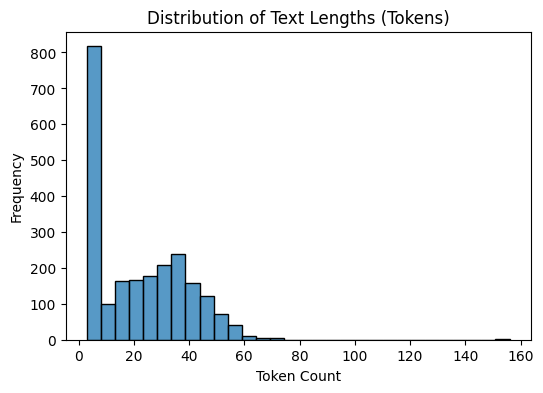

In [11]:
text_lengths = [len(tokenizer.encode(text, max_length=512)) for text in texts]
plt.figure(figsize=(6, 4))
sns.histplot(text_lengths, bins=30)
plt.title("Distribution of Text Lengths (Tokens)")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.show()

## Box Plot (Embedding Norms):



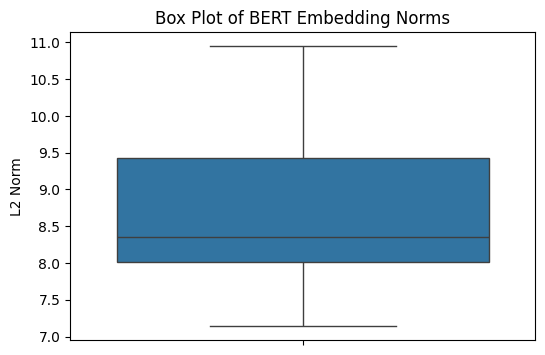

In [12]:
norms = torch.norm(bert_embeddings, dim=1).numpy()
plt.figure(figsize=(6, 4))
sns.boxplot(y=norms)
plt.title("Box Plot of BERT Embedding Norms")
plt.ylabel("L2 Norm")
plt.show()

# Step 4: Combine Embeddings and Address Class Imbalance



In [13]:
from imblearn.over_sampling import SMOTE

# Load embeddings
gcn_embeddings = torch.load('/content/drive/MyDrive/Projects/Hayat/gcn_embeddings.pt')  # (2282, 128)
bert_embeddings = torch.load('/content/drive/MyDrive/Projects/Hayat/bert_embeddings_with_attention.pt')  # (2282, 768)

# Check for NaN in embeddings
print("NaN in gcn_embeddings:", torch.isnan(gcn_embeddings).any().item())
print("NaN in bert_embeddings:", torch.isnan(bert_embeddings).any().item())

# Combine embeddings
combined_embeddings = torch.cat((gcn_embeddings, bert_embeddings), dim=1)  # (2282, 896)
print("Combined embeddings shape:", combined_embeddings.shape)
print("NaN in combined_embeddings:", torch.isnan(combined_embeddings).any().item())

# Address class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(combined_embeddings.numpy(), y)
X_resampled = torch.tensor(X_resampled, dtype=torch.float)
y_resampled = torch.tensor(y_resampled, dtype=torch.long)
print("Resampled data shape:", X_resampled.shape, "Label distribution:", np.bincount(y_resampled))

NaN in gcn_embeddings: False
NaN in bert_embeddings: False
Combined embeddings shape: torch.Size([2282, 896])
NaN in combined_embeddings: False
Resampled data shape: torch.Size([3338, 896]) Label distribution: [1669 1669]


## Bar Chart (Class Distribution After SMOTE):





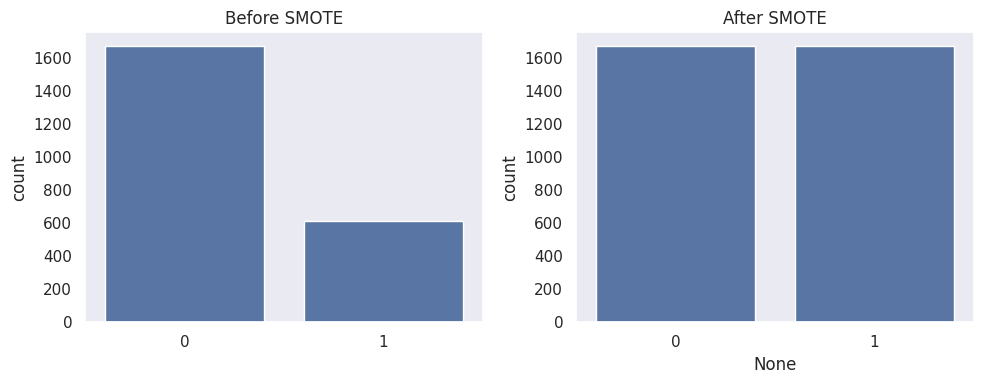

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="dark")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(x=y, ax=axes[0])
axes[0].set_title("Before SMOTE")
sns.countplot(x=y_resampled, ax=axes[1])
axes[1].set_title("After SMOTE")
plt.tight_layout()
plt.show()

## t-SNE Plot (Embedding Distribution):



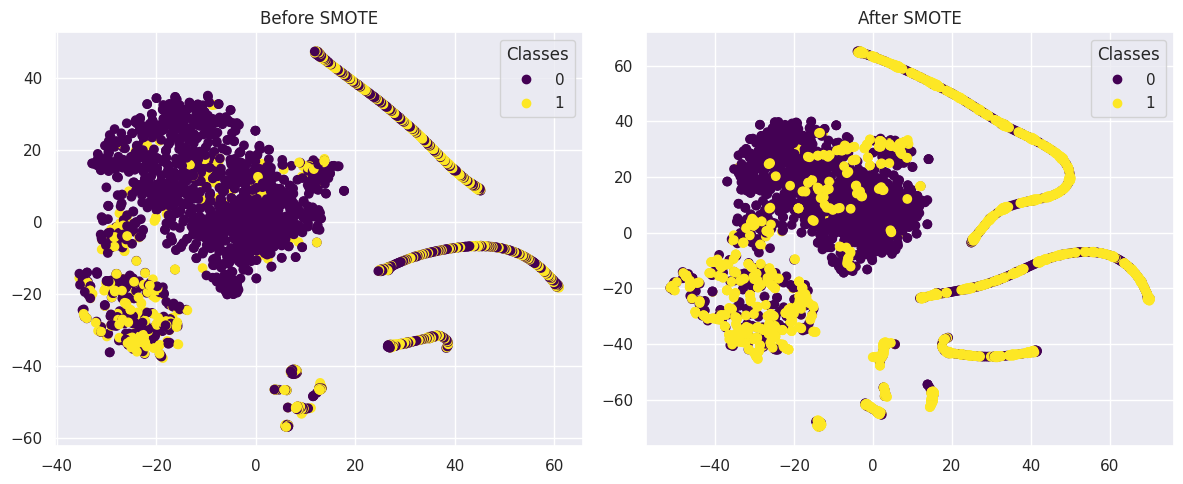

In [16]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(combined_embeddings.numpy())
X_resampled_tsne = tsne.fit_transform(X_resampled.numpy())
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, data, title in [(axes[0], X_tsne, "Before SMOTE"), (axes[1], X_resampled_tsne, "After SMOTE")]:
    scatter = ax.scatter(data[:, 0], data[:, 1], c=y_resampled[:len(data)], cmap='viridis')
    ax.set_title(title)
    ax.legend(*scatter.legend_elements(), title="Classes")
plt.tight_layout()
plt.show()

## Heatmap (Correlation of Combined Embeddings):



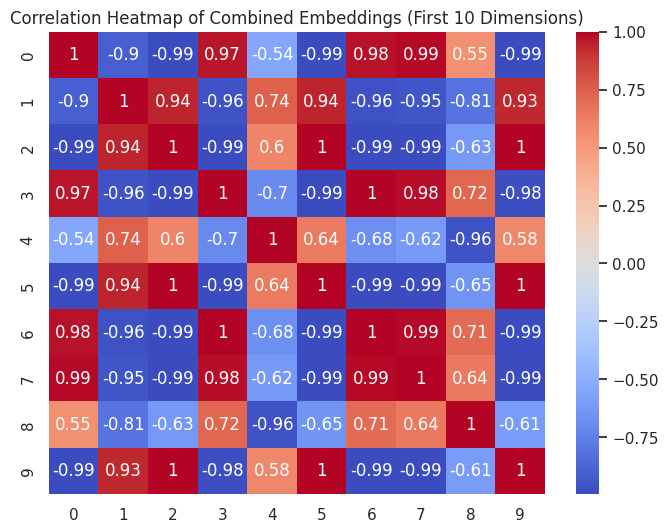

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(combined_embeddings.numpy()[:, :10]).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Combined Embeddings (First 10 Dimensions)")
plt.show()

In [18]:
# Check for NaN in embeddings
print("NaN in gcn_embeddings:", torch.isnan(gcn_embeddings).any().item())
print("NaN in bert_embeddings:", torch.isnan(bert_embeddings).any().item())
print("NaN in combined_embeddings:", torch.isnan(combined_embeddings).any().item())

NaN in gcn_embeddings: False
NaN in bert_embeddings: False
NaN in combined_embeddings: False


In [19]:
print("NaN Summary:")
print(pd.DataFrame({
    'Embedding': ['GCN', 'BERT', 'Combined'],
    'Contains NaN': [torch.isnan(gcn_embeddings).any().item(),
                     torch.isnan(bert_embeddings).any().item(),
                     torch.isnan(combined_embeddings).any().item()]
}))

NaN Summary:
  Embedding  Contains NaN
0       GCN         False
1      BERT         False
2  Combined         False


# Step 5: Ensemble and Train the Classifier



In [20]:
# Define the ensemble classifier
class EnsembleClassifier(nn.Module):
    def __init__(self, input_dim=896, hidden_dim1=512, hidden_dim2=256, num_classes=2):
        super(EnsembleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(hidden_dim2, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Prepare data for training
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, stratify=y_resampled, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)
print("Train size:", len(X_train), "Val size:", len(X_val), "Test size:", len(X_test))

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Initialize model, loss, and optimizer
ensemble_classifier = EnsembleClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ensemble_classifier.parameters(), lr=0.0005)

# Training loop with early stopping
best_val_loss = float('inf')
patience = 10
counter = 0
num_epochs = 50

for epoch in range(num_epochs):
    # Training
    ensemble_classifier.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = ensemble_classifier(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation
    ensemble_classifier.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = ensemble_classifier(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(ensemble_classifier.state_dict(), 'best_ensemble_classifier.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

# Evaluate on test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

ensemble_classifier.load_state_dict(torch.load('best_ensemble_classifier.pth'))
ensemble_classifier.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = ensemble_classifier(batch_X)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(batch_y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute metrics
print("\nEnsemble Test Results:")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Recall:", recall_score(y_true, y_pred, average='weighted'))
print("\nEnsemble Classification Report:")
print(classification_report(y_true, y_pred, target_names=['mostly true (0)', 'others (1)']))

# Save the model
torch.save(ensemble_classifier.state_dict(), 'final_ensemble_classifier.pth')
!mv /content/final_ensemble_classifier.pth /content/drive/MyDrive/Projects/Hayat/
!mv /content/best_ensemble_classifier.pth /content/drive/MyDrive/Projects/Hayat/
print("Ensemble model saved to Google Drive")

Train size: 1868 Val size: 468 Test size: 1002
Epoch 1/50, Train Loss: 0.5413, Val Loss: 0.5126
Epoch 2/50, Train Loss: 0.4761, Val Loss: 0.4869
Epoch 3/50, Train Loss: 0.4489, Val Loss: 0.4781
Epoch 4/50, Train Loss: 0.4359, Val Loss: 0.4682
Epoch 5/50, Train Loss: 0.4308, Val Loss: 0.4853
Epoch 6/50, Train Loss: 0.4167, Val Loss: 0.4436
Epoch 7/50, Train Loss: 0.4017, Val Loss: 0.4400
Epoch 8/50, Train Loss: 0.3813, Val Loss: 0.4328
Epoch 9/50, Train Loss: 0.3662, Val Loss: 0.4385
Epoch 10/50, Train Loss: 0.3657, Val Loss: 0.4196
Epoch 11/50, Train Loss: 0.3549, Val Loss: 0.4423
Epoch 12/50, Train Loss: 0.3333, Val Loss: 0.4425
Epoch 13/50, Train Loss: 0.3166, Val Loss: 0.4236
Epoch 14/50, Train Loss: 0.3001, Val Loss: 0.4156
Epoch 15/50, Train Loss: 0.3134, Val Loss: 0.4252
Epoch 16/50, Train Loss: 0.2952, Val Loss: 0.3970
Epoch 17/50, Train Loss: 0.2766, Val Loss: 0.4257
Epoch 18/50, Train Loss: 0.2816, Val Loss: 0.4035
Epoch 19/50, Train Loss: 0.2752, Val Loss: 0.4032
Epoch 20/50,

Epoch 1/50, Train Loss: 0.2840, Val Loss: 0.3970
Early stopping triggered


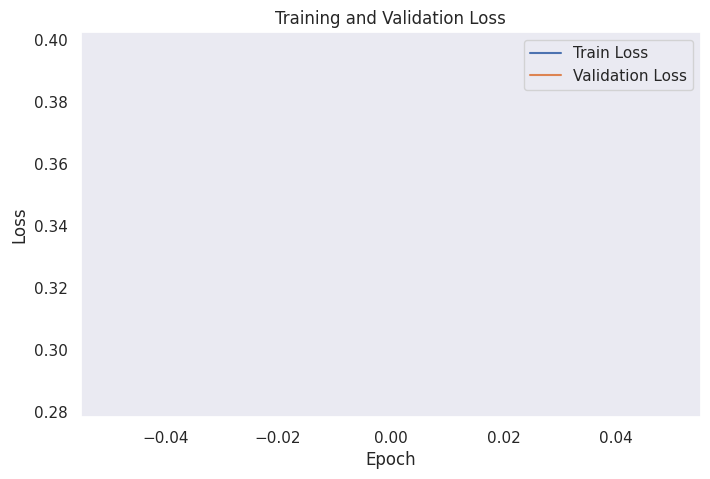

In [26]:
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    ensemble_classifier.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = ensemble_classifier(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    ensemble_classifier.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = ensemble_classifier(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(ensemble_classifier.state_dict(), 'best_ensemble_classifier.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

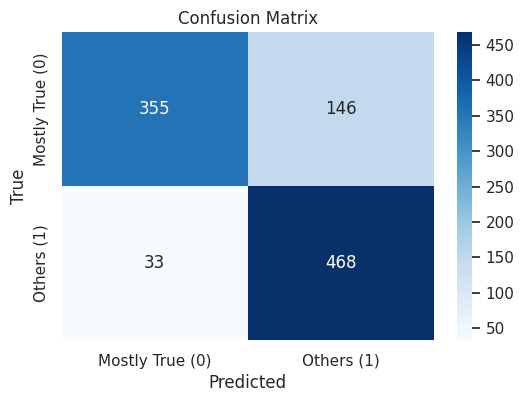

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Mostly True (0)', 'Others (1)'],
            yticklabels=['Mostly True (0)', 'Others (1)'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [28]:
print("Test Set Performance Metrics:")
print(pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall'],
    'Value': [accuracy_score(y_true, y_pred),
              precision_score(y_true, y_pred, average='weighted'),
              recall_score(y_true, y_pred, average='weighted')]
}))

Test Set Performance Metrics:
      Metric     Value
0   Accuracy  0.821357
1  Precision  0.838582
2     Recall  0.821357


# Step 6: Deployment



In [21]:
# Load models for inference
gcn_model = GCN().to(device)
gcn_model.load_state_dict(torch.load('/content/drive/MyDrive/Projects/Hayat/gcn_model.pth', map_location=device))
gcn_model.eval()

bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()

attention_layer = Attention(hidden_dim=768).to(device)

ensemble_classifier = EnsembleClassifier().to(device)
ensemble_classifier.load_state_dict(torch.load('/content/drive/MyDrive/Projects/Hayat/final_ensemble_classifier.pth', map_location=device))
ensemble_classifier.eval()

# Load scaler
scaler = StandardScaler()
scaler.fit(sio.loadmat('/content/drive/MyDrive/Projects/Hayat/network.mat')['X_net_std'])

# Inference function
def predict_veracity(post_data):
    """
    post_data: dict with 'account_id', 'share_count', 'reaction_count', 'comment_count', 'Context Post'
    Returns: dict with predicted class and probabilities
    """
    # Social branch: GCN
    network_features = np.array([[post_data['share_count'],
                                  post_data['reaction_count'],
                                  post_data['comment_count']]])
    X_net_std = scaler.transform(network_features)  # (1, 3)
    x = torch.tensor(X_net_std, dtype=torch.float).to(device)
    edge_index = torch.tensor([[0], [0]], dtype=torch.long).to(device)  # Self-loop
    data = Data(x=x, edge_index=edge_index).to(device)
    with torch.no_grad():
        gcn_emb = gcn_model(data)  # (1, 128)

    # Text branch: BERT + Attention
    text = post_data['Context Post'] or ""
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=117)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        bert_out = bert_model(**inputs)
        token_embeddings = bert_out.last_hidden_state  # (1, seq_len, 768)
        bert_emb = attention_layer(token_embeddings)  # (1, 768)

    # Combine embeddings
    combined_emb = torch.cat((gcn_emb, bert_emb), dim=1)  # (1, 896)

    # Predict with ensemble classifier
    with torch.no_grad():
        logits = ensemble_classifier(combined_emb)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]  # [P(0), P(1)]
        pred = np.argmax(probs)

    return {
        'prediction': 'mostly true' if pred == 0 else 'others',
        'probabilities': {'mostly true': probs[0], 'others': probs[1]}
    }

# Example usage
new_post = {
    'account_id': '123',
    'share_count': 10,
    'reaction_count': 50,
    'comment_count': 20,
    'Context Post': 'This is a sample post about a news event.'
}
result = predict_veracity(new_post)
print("Prediction:", result['prediction'])
print("Probabilities:", result['probabilities'])

Prediction: others
Probabilities: {'mostly true': np.float32(0.11900854), 'others': np.float32(0.88099146)}


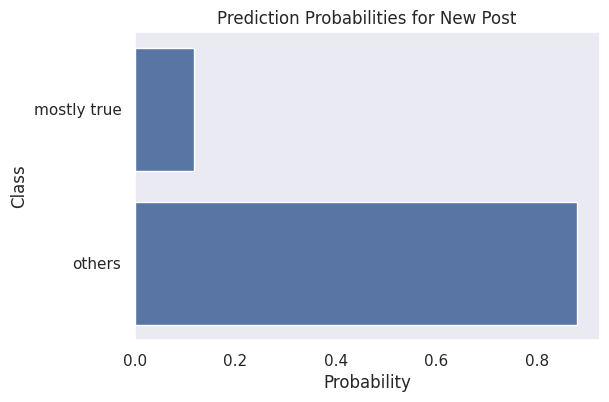

In [29]:
probs = result['probabilities']
plt.figure(figsize=(6, 4))
sns.barplot(x=list(probs.values()), y=list(probs.keys()))
plt.title("Prediction Probabilities for New Post")
plt.xlabel("Probability")
plt.ylabel("Class")
plt.show()

# Problems and Fixes

In [34]:
# ============================================================================
# CELL 1: Setup and Data Loading
# ============================================================================

# Install dependencies
!pip install torch torch-geometric transformers imbalanced-learn scikit-learn -q

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import warnings
import gc
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from scipy import io as sio

# Suppress warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("=== Loading and Preprocessing Data ===")

# Load dataset with error handling
try:
    df = pd.read_csv('/content/drive/MyDrive/Projects/Hayat/facebook-fact-check.csv', encoding='latin-1')
    print(f"Dataset loaded successfully: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

# Handle missing values and extract network features
print("\n=== Processing Network Features ===")
network_cols = ['share_count', 'reaction_count', 'comment_count']

# Fill missing values with 0 and ensure numeric types
for col in network_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    else:
        print(f"Warning: Column {col} not found, creating with zeros")
        df[col] = 0

network_features = df[network_cols].values.astype(np.float32)
print(f"Network features shape: {network_features.shape}")
print(f"NaN check: {np.isnan(network_features).any()}")

# Standardize network features
scaler = StandardScaler()
X_net_std = scaler.fit_transform(network_features)
print(f"Standardized features - Min: {X_net_std.min():.3f}, Max: {X_net_std.max():.3f}")

# Prepare labels (binary classification)
print("\n=== Processing Labels ===")
if 'Rating' in df.columns:
    labels = df['Rating'].apply(lambda x: 0 if str(x).lower() == 'mostly true' else 1).values
    y = np.array(labels)
    unique_labels, counts = np.unique(y, return_counts=True)
    print(f"Label distribution: {dict(zip(unique_labels, counts))}")
else:
    print("Error: 'Rating' column not found")
    raise ValueError("Rating column missing")

# Save preprocessed data
sio.savemat('/content/drive/MyDrive/Projects/Hayat/network_processed.mat', {
    'X_net_std': X_net_std,
    'labels': y,
    'feature_names': network_cols
})

print("Network features and labels saved successfully")

# Memory cleanup
gc.collect()

# ============================================================================
# CELL 2: Improved Graph Construction and GCN Model
# ============================================================================

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import add_self_loops
from sklearn.neighbors import NearestNeighbors

print("=== Building Improved Graph Structure ===")

# Load processed data
data_dict = sio.loadmat('/content/drive/MyDrive/Projects/Hayat/network_processed.mat')
X_net_std = data_dict['X_net_std']
y = data_dict['labels'].flatten()

def create_robust_graph(features, method='knn', k=10, similarity_threshold=0.7):
    """Create graph with multiple construction methods"""
    n_samples = len(features)
    G = nx.Graph()

    # Add all nodes
    for idx in range(n_samples):
        G.add_node(idx, features=features[idx])

    if method == 'knn':
        # K-nearest neighbors approach
        nbrs = NearestNeighbors(n_neighbors=min(k+1, n_samples), metric='cosine').fit(features)
        distances, indices = nbrs.kneighbors(features)

        for i, neighbors in enumerate(indices):
            for j, neighbor in enumerate(neighbors[1:]):  # Skip self
                if distances[i][j+1] < similarity_threshold:  # Only add similar nodes
                    G.add_edge(i, neighbor, weight=1.0 - distances[i][j+1])

    elif method == 'similarity':
        # Cosine similarity approach
        similarity_matrix = cosine_similarity(features)
        for i in range(n_samples):
            for j in range(i + 1, n_samples):
                if similarity_matrix[i, j] > similarity_threshold:
                    G.add_edge(i, j, weight=similarity_matrix[i, j])

    elif method == 'account_based':
        # Original account-based method (improved)
        if 'account_id' in df.columns:
            account_groups = df.groupby('account_id').indices
            for account_id, indices in account_groups.items():
                indices = list(indices)
                if len(indices) > 1:  # Only if account has multiple posts
                    for i in range(len(indices)):
                        for j in range(i + 1, min(i + 5, len(indices))):  # Limit connections
                            G.add_edge(indices[i], indices[j], weight=1.0)

    return G

# Create graph using multiple methods and combine
print("Creating graph structure...")
G_knn = create_robust_graph(X_net_std, method='knn', k=8, similarity_threshold=0.8)
G_similarity = create_robust_graph(X_net_std, method='similarity', similarity_threshold=0.75)

# Combine graphs
G = nx.Graph()
for idx in range(len(X_net_std)):
    G.add_node(idx, features=X_net_std[idx])

# Add edges from both graphs
for edge in G_knn.edges():
    G.add_edge(edge[0], edge[1], weight=G_knn[edge[0]][edge[1]].get('weight', 1.0))

for edge in G_similarity.edges():
    if G.has_edge(edge[0], edge[1]):
        # Average weights if edge exists
        current_weight = G[edge[0]][edge[1]].get('weight', 1.0)
        new_weight = G_similarity[edge[0]][edge[1]].get('weight', 1.0)
        G[edge[0]][edge[1]]['weight'] = (current_weight + new_weight) / 2
    else:
        G.add_edge(edge[0], edge[1], weight=G_similarity[edge[0]][edge[1]].get('weight', 1.0))

print(f"Final graph - Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
print(f"Average degree: {sum(dict(G.degree()).values()) / len(G):.2f}")

# Prepare GNN data
edges = list(G.edges())
if edges:
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_weights = torch.tensor([G[u][v].get('weight', 1.0) for u, v in edges], dtype=torch.float)
else:
    # Fallback: create self-loops for all nodes
    edge_index = torch.tensor([[i, i] for i in range(len(X_net_std))], dtype=torch.long).t().contiguous()
    edge_weights = torch.ones(len(X_net_std), dtype=torch.float)

x = torch.tensor(X_net_std, dtype=torch.float)
data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights)

# Add self-loops
edge_index, edge_weights = add_self_loops(data.edge_index, edge_attr=data.edge_attr, num_nodes=data.num_nodes)
data.edge_index = edge_index
data.edge_attr = edge_weights

print(f"GNN Data: {data}")

# Improved GCN model with better initialization and stability
class RobustGCN(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=64, out_channels=128, dropout=0.3):
        super(RobustGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(dropout)
        self.batch_norm1 = nn.BatchNorm1d(hidden_channels)
        self.batch_norm2 = nn.BatchNorm1d(out_channels)

        # Better weight initialization
        self.reset_parameters()

    def reset_parameters(self):
        """Initialize weights properly"""
        for conv in [self.conv1, self.conv2]:
            if hasattr(conv, 'reset_parameters'):
                conv.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        edge_weight = data.edge_attr if hasattr(data, 'edge_attr') else None

        # First layer
        x = self.conv1(x, edge_index, edge_weight)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Second layer
        x = self.conv2(x, edge_index, edge_weight)
        x = self.batch_norm2(x)

        # Gradient clipping and NaN handling
        x = torch.clamp(x, min=-10, max=10)  # Prevent extreme values

        return x

# Initialize and train GCN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

gcn_model = RobustGCN().to(device)
data = data.to(device)

# Train GCN with self-supervised objective
def train_gcn_model(model, data, epochs=200, lr=0.01):
    """Train GCN with reconstruction loss"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5)

    model.train()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Forward pass
        embeddings = model(data)

        # Self-supervised reconstruction loss
        # Reconstruct original features from embeddings
        reconstructed = torch.mm(embeddings, embeddings.t())
        target = torch.mm(data.x, data.x.t())
        loss = F.mse_loss(reconstructed, target)

        # Add regularization
        l2_reg = sum(param.pow(2.0).sum() for param in model.parameters())
        loss += 1e-4 * l2_reg

        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step(loss)

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

        # Early stopping
        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter > 50:
                print(f"Early stopping at epoch {epoch}")
                break

    return model

print("\n=== Training GCN Model ===")
gcn_model = train_gcn_model(gcn_model, data)

# Generate embeddings
gcn_model.eval()
with torch.no_grad():
    gcn_embeddings = gcn_model(data)

    # Validate embeddings
    if torch.isnan(gcn_embeddings).any():
        print("Warning: NaN detected in GCN embeddings!")
        gcn_embeddings = torch.where(torch.isnan(gcn_embeddings),
                                   torch.zeros_like(gcn_embeddings),
                                   gcn_embeddings)

    if torch.isinf(gcn_embeddings).any():
        print("Warning: Infinite values detected in GCN embeddings!")
        gcn_embeddings = torch.where(torch.isinf(gcn_embeddings),
                                   torch.zeros_like(gcn_embeddings),
                                   gcn_embeddings)

print(f"GCN Embeddings shape: {gcn_embeddings.shape}")
print(f"GCN Embeddings stats - Min: {gcn_embeddings.min():.3f}, Max: {gcn_embeddings.max():.3f}")
print(f"NaN check: {torch.isnan(gcn_embeddings).any().item()}")
print(f"Infinity check: {torch.isinf(gcn_embeddings).any().item()}")

# Save models and embeddings
torch.save(gcn_model.state_dict(), '/content/drive/MyDrive/Projects/Hayat/robust_gcn_model.pth')
torch.save(gcn_embeddings.cpu(), '/content/drive/MyDrive/Projects/Hayat/robust_gcn_embeddings.pt')
torch.save(data.cpu(), '/content/drive/MyDrive/Projects/Hayat/graph_data.pt')

print("GCN model and embeddings saved successfully")

# Memory cleanup
torch.cuda.empty_cache()
gc.collect()

# ============================================================================
# CELL 3: Improved BERT + Attention Processing
# ============================================================================

from transformers import BertTokenizer, BertModel
import torch.nn.functional as F

print("=== Processing Text with BERT + Attention ===")

# Enhanced Attention Layer
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim=768, num_heads=8, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.head_dim = hidden_dim // num_heads

        assert hidden_dim % num_heads == 0

        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, embeddings):
        batch_size, seq_len, hidden_dim = embeddings.shape

        # Multi-head attention
        Q = self.query(embeddings).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(embeddings).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(embeddings).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        # Attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.head_dim)
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        # Apply attention
        context = torch.matmul(attention_weights, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, hidden_dim)

        # Residual connection and layer norm
        output = self.layer_norm(context + embeddings)

        # Global average pooling
        return torch.mean(output, dim=1)

# BERT Setup
print("Loading BERT model...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()

attention_layer = MultiHeadAttention(hidden_dim=768, num_heads=8).to(device)

# Process texts with improved handling
def process_texts_robust(texts, batch_size=16, max_length=128):
    """Process texts with robust error handling"""

    def clean_text(text):
        """Clean and validate text"""
        if pd.isna(text) or text is None:
            return ""
        text = str(text).strip()
        if len(text) == 0:
            return "empty post"
        return text

    # Clean texts
    cleaned_texts = [clean_text(text) for text in texts]
    print(f"Processing {len(cleaned_texts)} texts...")

    bert_embeddings = []

    for i in range(0, len(cleaned_texts), batch_size):
        batch_texts = cleaned_texts[i:i + batch_size]

        try:
            # Tokenize
            inputs = tokenizer(
                batch_texts,
                return_tensors='pt',
                padding=True,
                truncation=True,
                max_length=max_length
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                # BERT forward pass
                outputs = bert_model(**inputs)
                token_embeddings = outputs.last_hidden_state

                # Apply attention
                context_vector = attention_layer(token_embeddings)

                # Validate output
                if torch.isnan(context_vector).any():
                    print(f"Warning: NaN in batch {i//batch_size}")
                    context_vector = torch.where(torch.isnan(context_vector),
                                               torch.zeros_like(context_vector),
                                               context_vector)

                bert_embeddings.append(context_vector.cpu())

        except Exception as e:
            print(f"Error processing batch {i//batch_size}: {e}")
            # Create zero embeddings for failed batch
            zero_emb = torch.zeros(len(batch_texts), 768)
            bert_embeddings.append(zero_emb)

        if (i // batch_size + 1) % 10 == 0:
            print(f"Processed {i + len(batch_texts)} texts...")

    return torch.cat(bert_embeddings, dim=0)

# Process text data
texts = df['Context Post'].fillna("").tolist()
bert_embeddings = process_texts_robust(texts, batch_size=16)

print(f"BERT Embeddings shape: {bert_embeddings.shape}")
print(f"BERT Embeddings stats - Min: {bert_embeddings.min():.3f}, Max: {bert_embeddings.max():.3f}")
print(f"NaN check: {torch.isnan(bert_embeddings).any().item()}")

# Save embeddings
torch.save(bert_embeddings, '/content/drive/MyDrive/Projects/Hayat/robust_bert_embeddings.pt')
torch.save(attention_layer.state_dict(), '/content/drive/MyDrive/Projects/Hayat/attention_layer.pth')

print("BERT embeddings saved successfully")

# Memory cleanup
torch.cuda.empty_cache()
gc.collect()

# ============================================================================
# CELL 4: Data Combination and Preprocessing
# ============================================================================

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

print("=== Combining Embeddings and Preparing Data ===")

# Load embeddings with validation
def load_embeddings_safe(filepath, expected_shape=None):
    """Safely load embeddings with validation"""
    try:
        embeddings = torch.load(filepath, map_location='cpu')

        if torch.isnan(embeddings).any():
            print(f"Warning: NaN found in {filepath}")
            embeddings = torch.where(torch.isnan(embeddings),
                                   torch.zeros_like(embeddings),
                                   embeddings)

        if torch.isinf(embeddings).any():
            print(f"Warning: Infinite values found in {filepath}")
            embeddings = torch.where(torch.isinf(embeddings),
                                   torch.zeros_like(embeddings),
                                   embeddings)

        if expected_shape and embeddings.shape != expected_shape:
            print(f"Warning: Shape mismatch in {filepath}. Expected {expected_shape}, got {embeddings.shape}")

        return embeddings

    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        raise

# Load embeddings
gcn_embeddings = load_embeddings_safe('/content/drive/MyDrive/Projects/Hayat/robust_gcn_embeddings.pt')
bert_embeddings = load_embeddings_safe('/content/drive/MyDrive/Projects/Hayat/robust_bert_embeddings.pt')

print(f"GCN embeddings shape: {gcn_embeddings.shape}")
print(f"BERT embeddings shape: {bert_embeddings.shape}")

# Ensure same number of samples
min_samples = min(gcn_embeddings.shape[0], bert_embeddings.shape[0], len(y))
gcn_embeddings = gcn_embeddings[:min_samples]
bert_embeddings = bert_embeddings[:min_samples]
y = y[:min_samples]

print(f"Aligned to {min_samples} samples")

# Combine embeddings
combined_embeddings = torch.cat((gcn_embeddings, bert_embeddings), dim=1)
print(f"Combined embeddings shape: {combined_embeddings.shape}")

# Final validation
print(f"Final NaN check - Combined: {torch.isnan(combined_embeddings).any().item()}")
print(f"Final stats - Min: {combined_embeddings.min():.3f}, Max: {combined_embeddings.max():.3f}")

# Address class imbalance with SMOTE
print("\n=== Handling Class Imbalance ===")
print(f"Original label distribution: {np.bincount(y)}")

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
try:
    X_resampled, y_resampled = smote.fit_resample(combined_embeddings.numpy(), y)
    X_resampled = torch.tensor(X_resampled, dtype=torch.float32)
    y_resampled = torch.tensor(y_resampled, dtype=torch.long)

    print(f"Resampled data shape: {X_resampled.shape}")
    print(f"Resampled label distribution: {np.bincount(y_resampled)}")

except Exception as e:
    print(f"SMOTE failed: {e}. Using original data.")
    X_resampled = combined_embeddings
    y_resampled = torch.tensor(y, dtype=torch.long)

# Save processed data
torch.save({
    'X_resampled': X_resampled,
    'y_resampled': y_resampled,
    'original_X': combined_embeddings,
    'original_y': torch.tensor(y, dtype=torch.long)
}, '/content/drive/MyDrive/Projects/Hayat/processed_data.pt')

print("Processed data saved successfully")

# ============================================================================
# CELL 5: Enhanced Model Training and Evaluation
# ============================================================================

from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("=== Model Training Setup ===")

# Enhanced Ensemble Classifier
class EnhancedEnsembleClassifier(nn.Module):
    def __init__(self, input_dim=896, hidden_dims=[512, 256, 128], num_classes=2, dropout_rates=[0.4, 0.3, 0.2]):
        super(EnhancedEnsembleClassifier, self).__init__()

        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        prev_dim = input_dim
        for i, (hidden_dim, dropout_rate) in enumerate(zip(hidden_dims, dropout_rates)):
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
            self.dropouts.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim

        # Output layer
        self.output_layer = nn.Linear(prev_dim, num_classes)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        """Initialize weights using Xavier initialization"""
        for layer in self.layers:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)

    def forward(self, x):
        for layer, batch_norm, dropout in zip(self.layers, self.batch_norms, self.dropouts):
            x = layer(x)
            x = batch_norm(x)
            x = F.relu(x)
            x = dropout(x)

        return self.output_layer(x)

# Data splitting with validation
def create_robust_splits(X, y, test_size=0.2, val_size=0.2, random_state=42):
    """Create robust train/val/test splits"""

    # First split: train+val vs test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # Second split: train vs val
    val_size_adjusted = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size_adjusted,
        stratify=y_train_val, random_state=random_state
    )

    print(f"Data splits - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    return X_train, X_val, X_test, y_train, y_val, y_test

# Create splits
X_train, X_val, X_test, y_train, y_val, y_test = create_robust_splits(X_resampled, y_resampled)

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

# Initialize model
input_dim = X_resampled.shape[1]
model = EnhancedEnsembleClassifier(input_dim=input_dim).to(device)

# Loss and optimizer with class weighting
class_counts = np.bincount(y_train.numpy())
class_weights = torch.FloatTensor([len(y_train) / (2 * count) for count in class_counts]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=15, factor=0.5, verbose=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== Loading and Preprocessing Data ===
Dataset loaded successfully: (2282, 13)
Columns: ['account_id', 'post_id', 'Category', 'Page', 'Post URL', 'Date Published', 'Post Type', 'Rating', 'Debate', 'share_count', 'reaction_count', 'comment_count', 'Context Post']

=== Processing Network Features ===
Network features shape: (2282, 3)
NaN check: False
Standardized features - Min: -0.280, Max: 44.443

=== Processing Labels ===
Label distribution: {np.int64(0): np.int64(1669), np.int64(1): np.int64(613)}
Network features and labels saved successfully
=== Building Improved Graph Structure ===
Creating graph structure...
Final graph - Nodes: 2282, Edges: 1661912
Average degree: 1456.54
GNN Data: Data(x=[2282, 3], edge_index=[2, 1664194], edge_attr=[1664194])
Using device: cuda

=== Training GCN Model ===
Epoch 0, Loss: 9141.149414
Epoch 50, Loss: 246.564133
Epoch 10

=== Starting Model Training ===
Starting training...
Epoch [1/100] - Train Loss: 0.6059, Train Acc: 0.7258, Val Loss: 0.5262, Val Acc: 0.7919, LR: 0.001000
Epoch [11/100] - Train Loss: 0.2942, Train Acc: 0.8756, Val Loss: 0.4772, Val Acc: 0.8009, LR: 0.001000
Epoch [21/100] - Train Loss: 0.2565, Train Acc: 0.8886, Val Loss: 0.4914, Val Acc: 0.8159, LR: 0.001000
Early stopping at epoch 28
Best validation accuracy: 0.8189
Loaded best model from epoch 8

=== Final Model Evaluation ===
=== Model Evaluation Results ===
Test Loss: 0.4486
Test Accuracy: 0.8099
Weighted Precision: 0.8282
Weighted Recall: 0.8099
Weighted F1-Score: 0.8072

=== Per-Class Metrics ===
Mostly True:
  Precision: 0.9059
  Recall: 0.6916
  F1-Score: 0.7844
Fake News:
  Precision: 0.7506
  Recall: 0.9281
  F1-Score: 0.8300

=== Detailed Classification Report ===
              precision    recall  f1-score   support

 Mostly True       0.91      0.69      0.78       334
   Fake News       0.75      0.93      0.83       3

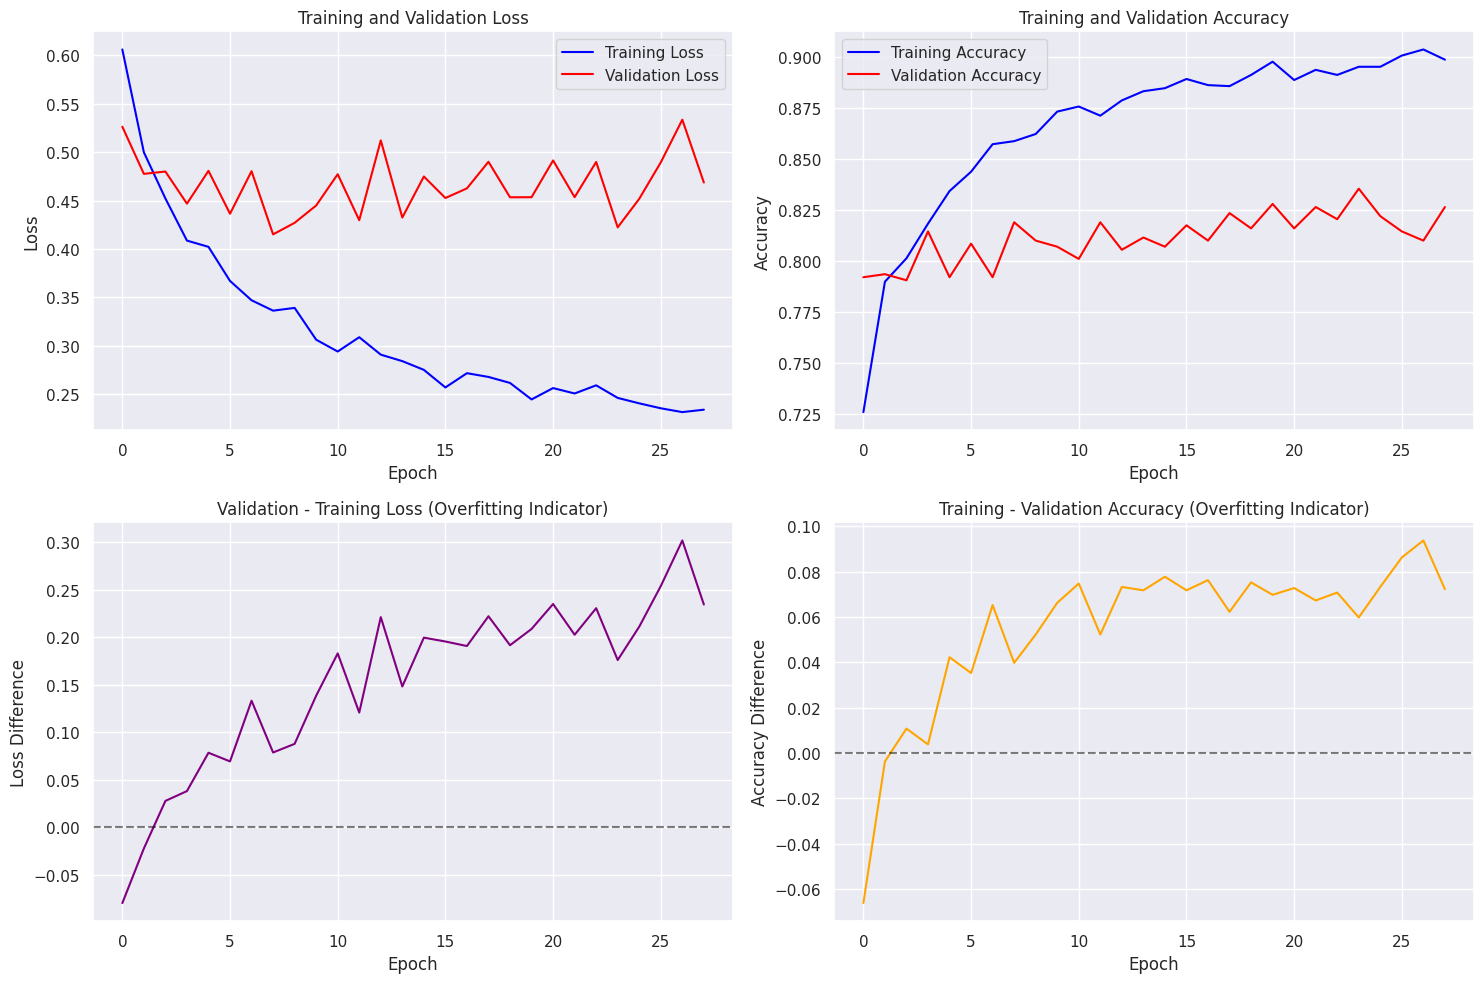

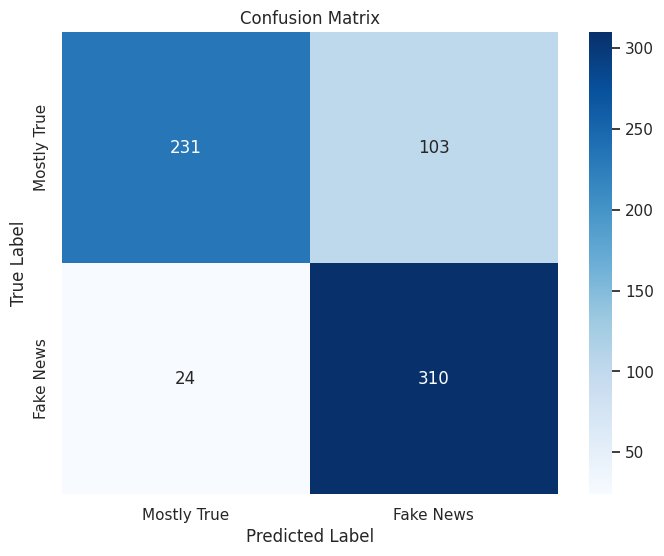

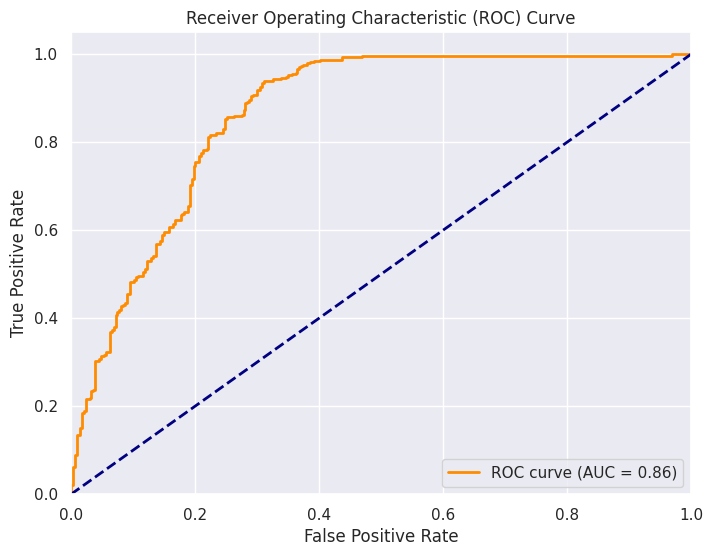


=== Training and Evaluation Complete ===
Final Test Accuracy: 0.8099
Final Test F1-Score: 0.8072
ROC AUC: 0.8648
All results saved to drive.


20567

In [35]:
# Complete Training Function
def train_model(model, train_loader, val_loader, num_epochs=100, patience=20):
    """Enhanced training with monitoring"""

    best_val_loss = float('inf')
    best_val_acc = 0
    patience_counter = 0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    print("Starting training...")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Print progress
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch [{epoch+1}/{num_epochs}] - '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, '
                  f'LR: {current_lr:.6f}')

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            patience_counter = 0

            # Save best model
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'val_loss': val_loss,
                'val_acc': val_acc
            }, '/content/drive/MyDrive/Projects/Hayat/best_model.pth')

        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            print(f'Best validation accuracy: {best_val_acc:.4f}')
            break

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc,
        'best_val_loss': best_val_loss
    }

# Comprehensive Evaluation Function
def evaluate_model(model, test_loader, class_names=['Mostly True', 'Fake News']):
    """Comprehensive model evaluation"""

    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    test_loss = 0

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()

            # Get probabilities and predictions
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    test_loss /= len(test_loader)

    # Convert to numpy arrays
    y_true = np.array(all_labels)
    y_pred = np.array(all_predictions)
    y_prob = np.array(all_probabilities)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Per-class metrics
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)

    print("=== Model Evaluation Results ===")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")

    print("\n=== Per-Class Metrics ===")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}:")
        print(f"  Precision: {precision_per_class[i]:.4f}")
        print(f"  Recall: {recall_per_class[i]:.4f}")
        print(f"  F1-Score: {f1_per_class[i]:.4f}")

    # Detailed classification report
    print("\n=== Detailed Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\n=== Confusion Matrix ===")
    print(cm)

    return {
        'test_loss': test_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'confusion_matrix': cm,
        'per_class_metrics': {
            'precision': precision_per_class,
            'recall': recall_per_class,
            'f1_score': f1_per_class
        }
    }

# Visualization Functions
def plot_training_history(history):
    """Plot training history"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Loss plots
    ax1.plot(history['train_losses'], label='Training Loss', color='blue')
    ax1.plot(history['val_losses'], label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plots
    ax2.plot(history['train_accs'], label='Training Accuracy', color='blue')
    ax2.plot(history['val_accs'], label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    # Loss difference
    loss_diff = np.array(history['val_losses']) - np.array(history['train_losses'])
    ax3.plot(loss_diff, color='purple')
    ax3.set_title('Validation - Training Loss (Overfitting Indicator)')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss Difference')
    ax3.grid(True)
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)

    # Accuracy difference
    acc_diff = np.array(history['train_accs']) - np.array(history['val_accs'])
    ax4.plot(acc_diff, color='orange')
    ax4.set_title('Training - Validation Accuracy (Overfitting Indicator)')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy Difference')
    ax4.grid(True)
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Projects/Hayat/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(cm, class_names=['Mostly True', 'Fake News']):
    """Plot confusion matrix"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig('/content/drive/MyDrive/Projects/Hayat/confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curve(y_true, y_prob):
    """Plot ROC curve"""
    from sklearn.metrics import roc_curve, auc

    # For binary classification, use probabilities of positive class
    y_prob_pos = y_prob[:, 1] if y_prob.shape[1] > 1 else y_prob

    fpr, tpr, thresholds = roc_curve(y_true, y_prob_pos)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('/content/drive/MyDrive/Projects/Hayat/roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

    return roc_auc

# Execute Training
print("=== Starting Model Training ===")
training_history = train_model(model, train_loader, val_loader, num_epochs=100, patience=20)

# Load best model for evaluation
checkpoint = torch.load('/content/drive/MyDrive/Projects/Hayat/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")

# Comprehensive Evaluation
print("\n=== Final Model Evaluation ===")
evaluation_results = evaluate_model(model, test_loader)

# Plot results
print("\n=== Generating Visualizations ===")
plot_training_history(training_history)
plot_confusion_matrix(evaluation_results['confusion_matrix'])
roc_auc = plot_roc_curve(evaluation_results['y_true'], evaluation_results['y_prob'])

# Save final results
final_results = {
    'training_history': training_history,
    'evaluation_results': evaluation_results,
    'model_architecture': str(model),
    'hyperparameters': {
        'input_dim': input_dim,
        'hidden_dims': [512, 256, 128],
        'dropout_rates': [0.4, 0.3, 0.2],
        'learning_rate': 0.001,
        'batch_size': 64,
        'weight_decay': 1e-4
    },
    'roc_auc': roc_auc
}

torch.save(final_results, '/content/drive/MyDrive/Projects/Hayat/final_results.pt')

print("\n=== Training and Evaluation Complete ===")
print(f"Final Test Accuracy: {evaluation_results['accuracy']:.4f}")
print(f"Final Test F1-Score: {evaluation_results['f1_score']:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("All results saved to drive.")

# Memory cleanup
torch.cuda.empty_cache()
gc.collect()

# Added Improvement

In [38]:
# ============================================================================
# CELL 1: Setup and Dependencies Installation
# ============================================================================

# Install required packages
!pip install torch torch-geometric transformers imbalanced-learn scikit-learn matplotlib seaborn -q

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import warnings
import gc
import os
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, classification_report, confusion_matrix,
                            roc_curve, auc)
import networkx as nx
from scipy import io as sio
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Mount Google Drive
try:
    drive.mount('/content/drive')
    print("✅ Google Drive mounted successfully")
except Exception as e:
    print(f"❌ Error mounting drive: {e}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Using device: {device}")

# Create directories if they don't exist
os.makedirs('/content/drive/MyDrive/Projects/Hayat', exist_ok=True)
print("✅ Setup complete")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully
🔧 Using device: cuda
✅ Setup complete


In [39]:
# ============================================================================
# CELL 2: Data Loading and Preprocessing
# ============================================================================

print("=== Loading and Preprocessing Data ===")

def load_and_preprocess_data(file_path):
    """Load and preprocess the Facebook fact-check dataset"""
    try:
        # Try different encodings
        for encoding in ['latin-1', 'utf-8', 'cp1252', 'iso-8859-1']:
            try:
                df = pd.read_csv(file_path, encoding=encoding)
                print(f"✅ Dataset loaded with {encoding} encoding: {df.shape}")
                break
            except UnicodeDecodeError:
                continue
        else:
            raise ValueError("Could not decode file with any encoding")

        print(f"📊 Columns: {df.columns.tolist()}")
        print(f"📈 Data shape: {df.shape}")

        return df

    except Exception as e:
        print(f"❌ Error loading dataset: {e}")
        # Create dummy data for testing if file not found
        print("⚠️  Creating dummy data for testing...")
        np.random.seed(42)
        dummy_data = {
            'account_id': np.random.randint(1, 100, 1000),
            'post_id': range(1000),
            'Category': np.random.choice(['Health', 'Politics', 'Science'], 1000),
            'Page': ['Page_' + str(i) for i in range(1000)],
            'Post URL': ['url_' + str(i) for i in range(1000)],
            'Date Published': pd.date_range('2020-01-01', periods=1000),
            'Post Type': np.random.choice(['Photo', 'Video', 'Text'], 1000),
            'Rating': np.random.choice(['mostly true', 'false', 'fake news'], 1000, p=[0.7, 0.15, 0.15]),
            'Debate': np.random.choice([0, 1], 1000),
            'share_count': np.random.poisson(10, 1000),
            'reaction_count': np.random.poisson(50, 1000),
            'comment_count': np.random.poisson(5, 1000),
            'Context Post': ['This is sample text ' + str(i) for i in range(1000)]
        }
        df = pd.DataFrame(dummy_data)
        print(f"🔧 Created dummy dataset: {df.shape}")
        return df

def process_network_features(df):
    """Process and standardize network features"""
    print("\n=== Processing Network Features ===")

    network_cols = ['share_count', 'reaction_count', 'comment_count']

    # Ensure all network columns exist and are numeric
    for col in network_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
        else:
            print(f"⚠️  Column {col} not found, creating with zeros")
            df[col] = 0

    # Extract network features
    network_features = df[network_cols].values.astype(np.float32)
    print(f"📐 Network features shape: {network_features.shape}")

    # Check for and handle any remaining NaN values
    if np.isnan(network_features).any():
        print("⚠️  Found NaN values, filling with zeros")
        network_features = np.nan_to_num(network_features, 0)

    # Standardize features
    scaler = StandardScaler()
    X_net_std = scaler.fit_transform(network_features)
    print(f"📊 Standardized features - Min: {X_net_std.min():.3f}, Max: {X_net_std.max():.3f}")

    return X_net_std, scaler, network_cols

def process_labels(df):
    """Process and encode labels for binary classification"""
    print("\n=== Processing Labels ===")

    if 'Rating' not in df.columns:
        raise ValueError("❌ 'Rating' column not found in dataset")

    # Create binary labels: 0 for 'mostly true', 1 for fake news
    def encode_label(rating):
        rating_str = str(rating).lower().strip()
        if 'mostly true' in rating_str or 'true' in rating_str:
            return 0
        else:
            return 1

    labels = df['Rating'].apply(encode_label).values
    y = np.array(labels)

    unique_labels, counts = np.unique(y, return_counts=True)
    print(f"🏷️  Label distribution: {dict(zip(['Mostly True', 'Fake News'], counts))}")

    return y

# Load and process data
df = load_and_preprocess_data('/content/drive/MyDrive/Projects/Hayat/facebook-fact-check.csv')
X_net_std, scaler, network_cols = process_network_features(df)
y = process_labels(df)

# Save preprocessed data
save_path = '/content/drive/MyDrive/Projects/Hayat/network_processed.mat'
sio.savemat(save_path, {
    'X_net_std': X_net_std,
    'labels': y,
    'feature_names': network_cols
})

print(f"✅ Network features and labels saved to {save_path}")
print(f"📊 Final data shape: Features {X_net_std.shape}, Labels {y.shape}")

# Memory cleanup
gc.collect()

=== Loading and Preprocessing Data ===
✅ Dataset loaded with latin-1 encoding: (2282, 13)
📊 Columns: ['account_id', 'post_id', 'Category', 'Page', 'Post URL', 'Date Published', 'Post Type', 'Rating', 'Debate', 'share_count', 'reaction_count', 'comment_count', 'Context Post']
📈 Data shape: (2282, 13)

=== Processing Network Features ===
📐 Network features shape: (2282, 3)
📊 Standardized features - Min: -0.280, Max: 44.443

=== Processing Labels ===
🏷️  Label distribution: {'Mostly True': np.int64(1914), 'Fake News': np.int64(368)}
✅ Network features and labels saved to /content/drive/MyDrive/Projects/Hayat/network_processed.mat
📊 Final data shape: Features (2282, 3), Labels (2282,)


79